<a href="https://colab.research.google.com/github/N-Efi/N-Efi/blob/main/Neuroflorist_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дипломный проект "Нерофлорист"

Студент Университета Искусственного Интеллекта Ника Витальевна Ефимова

Старт обучения - май 2021г.

Задача: генерация букетов с заданными цветами. 
В нашем случае - 24 типа монобукетов с двумя признаками: вид цветов (растений) и основной цвет букета

Защита 14.01.2022.

Представлена нейросеть обученного декодера

# 1. Подготовка: подключение библиотек, загрузка необходимых функций и предобученной модели декодера 

In [ ]:
# Подключение библиотек (избыточно)
import os # 
import numpy as np #
import tensorflow as tf # для работы с Тензорфлоу
from tensorflow.keras import utils # для работы с утилитами
from tensorflow.keras.preprocessing import image # для обработки изображений
#from tensorflow.keras.preprocessing import image_dataset_from_directory # может потребоваться для загрузки БД
import matplotlib.pyplot as plt # импорт библиотеки Матплотлиб для отрисовки графиков и изображений
from google.colab import files # для работы с файлами
from tensorflow.keras.preprocessing.image import ImageDataGenerator # для подачи входных данных с помощью генератора
from PIL import Image #Для отрисовки изображений
from tensorflow.keras import layers # импортируем слои 
from tensorflow.keras import models # импортируем модели
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, mse, mae # импортируем функции ошибок
from tensorflow.keras.optimizers import Adam # импорт оптимизатора
from tensorflow.keras.callbacks import LambdaCallback # для написания Callback
from IPython.display import clear_output, Image # для очистки выхода сети
from tensorflow.keras.utils import to_categorical # для преобразования меток в OHE
import tensorflow.keras.backend as K # для написания собственного слоя
from sklearn.metrics import confusion_matrix # для написания метрик
from tensorflow.keras.initializers import RandomNormal #Импортируем слой инициализации весов с номральным распределением
from tensorflow.keras.layers import  Activation # подключаем активации
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, Reshape # поключаем нужные нам слои
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, concatenate # поключаем нужные нам слои
from tensorflow.keras.models import Model # для работы с моделями
from keras.models import load_model # для загрузки предобученной моделиimport time # Имортируем, чтобы высчитать время работы каких-либо процессов
%matplotlib inline 

In [ ]:
from google.colab import drive # подключаем диск для загрузки предобученной модели
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Для работы предобученной модели
# функция создания собственного слоя
def sampling(args):
  '''
  sampling - функция создания собственного слоя
    вход:
      args - два слоя из котрых возьмем мат.ожидание и ст.отклонение
    выход:
      sampling_layer - собственный слой
  '''
  z_mean, z_log_var = args # раскусываем поданные на вход слои
  epsilon = K.random_normal(shape=(latent_dim,), mean=0., stddev=1.0) # керасовским методом делаем нормальное распределение c мат.ожиданием 0, ст.отклонением 1
  sampling_layer = z_mean + K.exp(z_log_var / 2) * epsilon # изменяем мат.ожидание и ст.отклонение путем сложения и произведения 
  return sampling_layer

# собственная функция ошибки для вариацинного автокодировщика (VAE)
def vae_loss(x, decoded):
  '''
  vae_loss - функция ошибки для VAE
    вход:
      x - истинные картинки (те, что поданы в качестве y)
      decoded - картинки, созданные VAE
    выход:
      res - значение ошибки
  '''
  # num_elements это наши метки, что мы через global получаем за каждую эпоху
  # по формуле кульбака-лейблера устанавливаем ошибку kl_loss
  kl_loss = -0.5 * K.sum(1.0 + z_log_var_model([x,num_elements]) - K.square(z_mean_model([x,num_elements])) - K.exp(z_log_var_model([x,num_elements])), axis=-1) 
  x = K.reshape(x, (-1, img_rows* img_cols*channels)) # меняем форму для последующего соответствия размеров
  decoded = K.reshape(decoded, (-1, img_rows*img_cols*channels)) # меняем форму для последующего соответствия размеров
  xent_loss =img_rows*img_cols*channels*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей

  res = (0.25*xent_loss + 0.75*kl_loss)/img_rows/img_cols/channels # получаем суммарную ошибку с учетом распределения и размеров пикселей
  return res

In [ ]:
# Для работы предобученной модели
# создадние объекта confusion_matrix для метрики Precision
class Precision:
    def __call__(self, y: np.ndarray, y_pred: np.ndarray) -> np.float64:
        return self.loss(y, y_pred)

    def loss(self, y: np.ndarray, y_pred: np.ndarray) -> np.float64:
        cm = confusion_matrix(y, y_pred)
        return np.mean(np.diag(cm) / np.sum(cm, axis=0))

Загрузка обученной модели

In [ ]:
# Для загрузки модели
custom_objects={'vae_loss':vae_loss,'Precision':Precision}

# Чтобы загрузить сохраненную модель, использующую vae_loss  и Precision
model1 = load_model('/content/drive/MyDrive/ДИПЛОМ AI/dec_dense_ok1.h5', custom_objects = custom_objects)
#model1.summary()

# 2. Проверка результатов декодера по всем классам

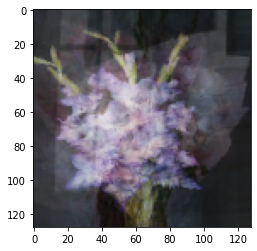

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(0, 24)[None, ...] # задаем lbl (0 - синие гладиолусы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

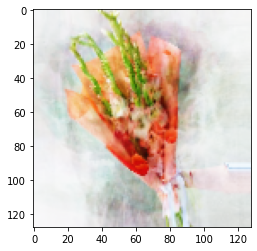

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(1, 24)[None, ...] # задаем lbl (1 - розовые гладиолусы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

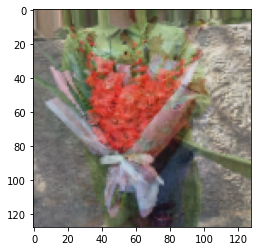

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(2, 24)[None, ...] # задаем lbl (2 - красные гладиолусы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

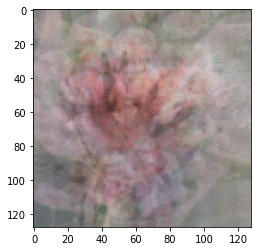

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(3, 24)[None, ...] # задаем lbl (3 - белые гладиолусы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

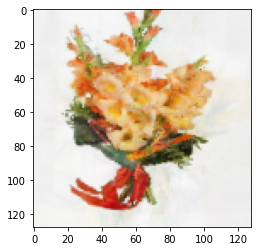

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(4, 24)[None, ...] # задаем lbl (4 - желтые гладиолусы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

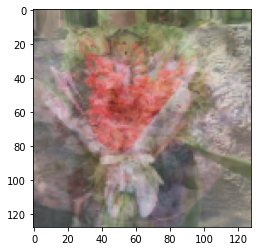

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(5, 24)[None, ...] # задаем lbl (5 - синие / фиолетовые гвоздики)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

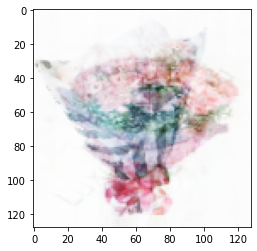

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(6, 24)[None, ...] # задаем lbl (6 - розовые гвоздики)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

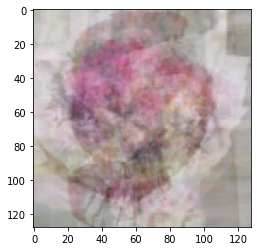

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(7, 24)[None, ...] # задаем lbl (7 - красные гвоздики)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

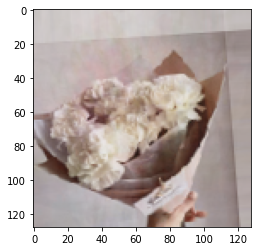

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(8, 24)[None, ...] # задаем lbl (8 - белые гвоздики)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

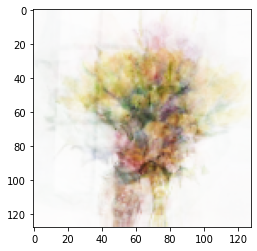

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(9, 24)[None, ...] # задаем lbl (9 - желтые гвоздики)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

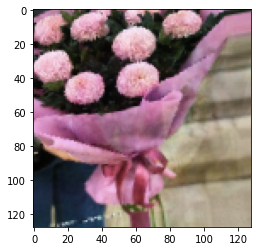

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(10, 24)[None, ...] # задаем lbl (10 - розовые хризантемы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

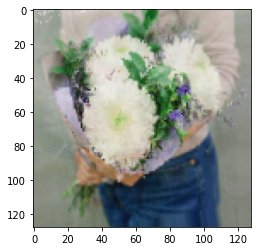

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(11, 24)[None, ...] # задаем lbl (11 - белые хризантемы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

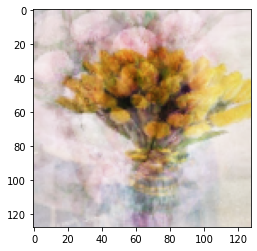

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(12, 24)[None, ...] # задаем lbl (12 - желтые хризантемы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

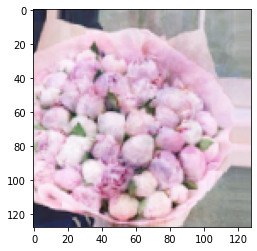

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(13, 24)[None, ...] # задаем lbl (13 - розовые пионы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

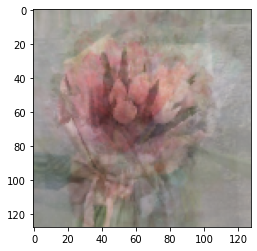

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(14, 24)[None, ...] # задаем lbl (14 - красные пионы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

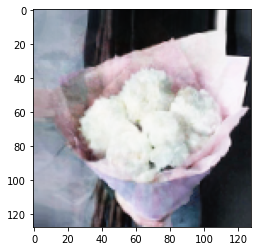

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(15, 24)[None, ...] # задаем lbl (15 - белые пионы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

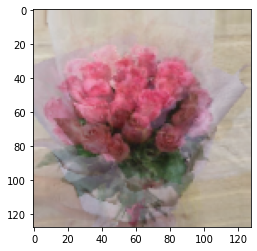

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(16, 24)[None, ...] # задаем lbl (16 - розовые розы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

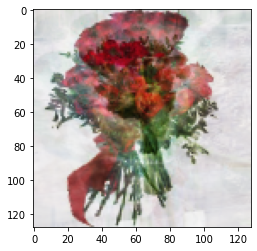

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(17, 24)[None, ...] # задаем lbl (17 - красные розы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

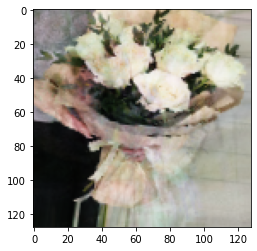

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(18, 24)[None, ...] # задаем lbl (18 - белые розы)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

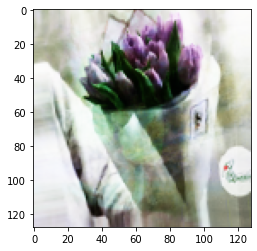

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(19, 24)[None, ...] # задаем lbl (19 - синие / фиолетовые тюльпаны)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

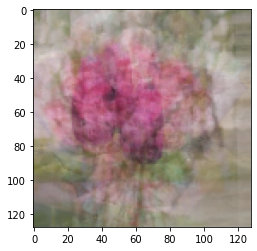

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(20, 24)[None, ...] # задаем lbl (20 - розовые тюльпаны)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

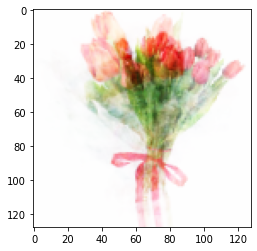

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(21, 24)[None, ...] # задаем lbl (21 - красные тюльпаны)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

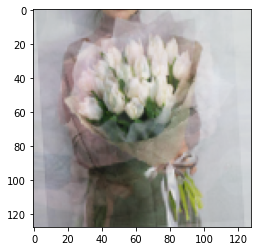

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(22, 24)[None, ...] # задаем lbl (22 - белые тюльпаны)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

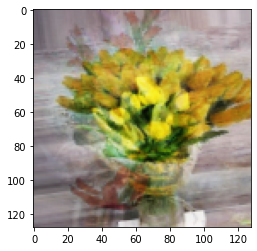

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
# predict decoder
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(23, 24)[None, ...] # задаем lbl (23 - желтые тюльпаны)
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившиеся картинки 
plt.show()
dig

# 3. Вызов через прямое задание параметров букета

Выберите название цветов для букета и введите соответствующее число: 

    гладиолусы - 1,  гвоздики - 2,  хризантемы - 3,  пионы - 4, розы - 5, тюльпаны - 6 
1
Выберите основной цвет букета и введите соответствующее число: 

    фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 
1


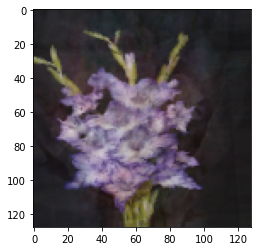

In [ ]:
# Зададим ввод параметров букета по желанию
n = int(input("""Выберите название цветов для букета и введите соответствующее число: \n
    гладиолусы - 1,  гвоздики - 2,  хризантемы - 3,  пионы - 4, розы - 5, тюльпаны - 6 \n"""))

if n==1:
  m1 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
if n==2:
  m2 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
   фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
if n==3:
  m3 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  белый - 2, желтый - 3 \n"""))
if n==4:
  m4 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  красный - 2,  белый - 3 \n"""))  
if n==5:
  m5 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  красный - 2,  белый - 3 \n"""))
if n==6:
  m6 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
# Определим номер класса по двум введенным признакам
if n==1:
    if m1==1:
      i=0
    if m1==2:
      i=1
    if m1==3:
      i=2
    if m1==4:
      i=3
    if m1==5:
      i=4
if n==2:
  if m2==1:
    i=5
  if  m2==2:
    i=6
  if  m2==3:
    i=7
  if m2==4:
    i=8
  if  m2==5:
    i=9
if n==3: 
  if m3==1:
    i=10
  if  m3==2:
    i=11
  if  m3==3:
    i=12
if n==4: 
  if m4==1:
    i=13
  if  m4==2:
    i=14
  if  m4==3:
    i=15
if n==5: 
  if m5==1:
    i=16
  if m5==2:
    i=17
  if m5==3:
    i=18
if n==6:
  if m6==1:
    i=19
  if  m6==2:
    i=20
  if  m6==3:
    i=21
  if  m6==4:
    i=22
  if  m6==5:
    i=23

#print(i)
rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
plt.imshow(rand)
plt.axis('off')
plt.show()
dig = to_categorical(i, 24)[None, ...] # задаем номер класса
predCVAE = model1.predict([rand, dig])
plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившееся изображение букета 
plt.show()  

# 4. Вызов через функцию

In [ ]:
# Зададим ввод параметров букета по желанию
n = 0 # зададим переменную
i = 0 # зададим переменную

def print_bouquet(n,  i):
  n = int(input("""Выберите название цветов для букета и введите соответствующее число: \n
    гладиолусы - 1,  гвоздики - 2,  хризантемы - 3,  пионы - 4, розы - 5, тюльпаны - 6 \n"""))
  if n==1:
    m1 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
  if n==2:
    m2 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
   фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
  if n==3:
    m3 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  белый - 2, желтый - 3 \n"""))
  if n==4:
    m4 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  красный - 2,  белый - 3 \n"""))  
  if n==5:
    m5 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    розовый - 1,  красный - 2,  белый - 3 \n"""))
  if n==6:
    m6 = int(input("""Выберите основной цвет букета и введите соответствующее число: \n
    фиолетовый - 1,  розовый - 2,  красный - 3,  белый - 4, желтый - 5 \n"""))
# Определим номер класса по двум введенным признакам
  if n==1:
    if m1==1:
      i=0
    if m1==2:
      i=1
    if m1==3:
      i=2
    if m1==4:
      i=3
    if m1==5:
      i=4
  if n==2:
    if m2==1:
      i=5
    if  m2==2:
      i=6
    if  m2==3:
      i=7
    if m2==4:
      i=8
    if  m2==5:
      i=9
  if n==3: 
    if m3==1:
      i=10
    if  m3==2:
      i=11
    if  m3==3:
      i=12
  if n==4: 
    if m4==1:
      i=13
    if  m4==2:
      i=14
    if  m4==3:
      i=15
  if n==5: 
    if m5==1:
      i=16
    if m5==2:
      i=17
    if m5==3:
      i=18
  if n==6:
    if m6==1:
      i=19
    if  m6==2:
      i=20
    if  m6==3:
      i=21
    if  m6==4:
      i=22
    if  m6==5:
      i=23

  #print(i)
  rand = np.random.normal(0, 2, 2024)[None, ...] # задаем вектор
  plt.imshow(rand)
  plt.axis('off')
  plt.show()
  dig = to_categorical(i, 24)[None, ...] # задаем номер класса
  predCVAE = model1.predict([rand, dig])
  plt.imshow(predCVAE.reshape((128, 128,3))) # выведем на экран получившееся изображение букета 
  plt.axis('off')
  plt.show()  
  return i

In [ ]:
print_bouquet(n,  i)

Выберите название цветов для букета и введите соответствующее число: 

    гладиолусы - 1,  гвоздики - 2,  хризантемы - 3,  пионы - 4, розы - 5, тюльпаны - 6 
1
